                                Date  Unemployment Rate UNRATE  \
count                            276                276.000000   
mean   2007-03-12 19:39:07.826086912                  5.744928   
min              1989-05-01 00:00:00                  3.500000   
25%              1998-05-24 06:00:00                  4.400000   
50%              2007-02-15 00:00:00                  5.400000   
75%              2016-04-16 06:00:00                  6.625000   
max              2024-10-01 00:00:00                 14.800000   
std                              NaN                  1.831406   

       Feds Funds FEDFUNDS  10-3 Yield Curve T10Y3M  \
count           276.000000               276.000000   
mean              2.964674                 1.435797   
min               0.050000                -1.890000   
25%               0.200000                 0.530000   
50%               2.530000                 1.475000   
75%               5.250000                 2.482500   
max               9.

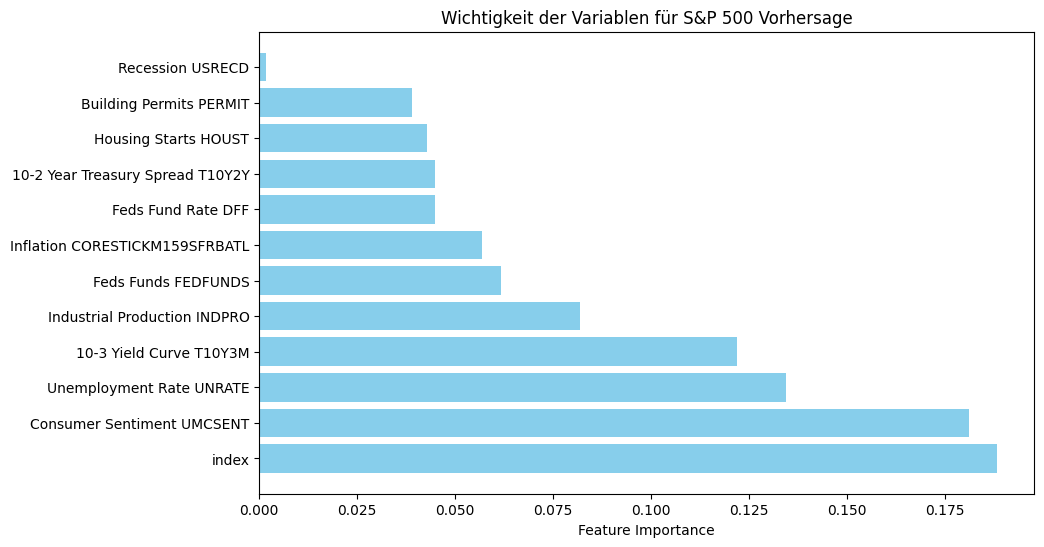

Stationaritätsergebnisse:
                             Variable  ADF Test Statistic       p-value  \
0            Unemployment Rate UNRATE           -3.382522  1.156931e-02   
1                 Feds Funds FEDFUNDS           -3.162849  2.223839e-02   
2             10-3 Yield Curve T10Y3M           -2.530746  1.081715e-01   
3        Industrial Production INDPRO           -1.850542  3.556730e-01   
4                Housing Starts HOUST           -1.593116  4.870504e-01   
5             Building Permits PERMIT           -1.566942  5.001752e-01   
6          Consumer Sentiment UMCSENT           -2.382515  1.467324e-01   
7      Inflation CORESTICKM159SFRBATL           -3.556265  6.654342e-03   
8    10-2 Year Treasury Spread T10Y2Y           -3.229162  1.835751e-02   
9                    Recession USRECD           -5.602309  1.256684e-06   
10                 Feds Fund Rate DFF           -2.934716  4.145743e-02   
11                              index           -0.890875  7.909626e-01   

c:\Users\chole\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\chole\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\chole\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\chole\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\chole\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  

In [ ]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.models import HoverTool, LinearAxis, Range1d
from math import pi

# Datenanalyse mit erweitertem Datensatz (1989)
# Korrelationsanalyse, Zeitreihenvisualisierung, Lineare Regression, Random Forest, Augmented-Dickey-Fuller-Test, Granger Kausalitätstests


# Daten laden
df = pd.read_csv('combined.csv', parse_dates=['Date'])

# Konvertiere alle Spalten in numerische Werte
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Entferne fehlende Werte
df.dropna(how='any', inplace=True)

print(df.describe())

# Berechne die Korrelationsmatrix
correlation_matrix = df.corr()

# Korrelationsmatrix als Heatmap
corr_fig = figure(title='Correlation Matrix', x_range=list(df.columns[1:]), y_range=list(df.columns[1:]))
corr_fig.image(image=[correlation_matrix.values], x=0, y=0, dw=len(df.columns[1:]), dh=len(df.columns[1:]), palette='Spectral11')
corr_fig.xaxis.major_label_orientation = pi/4
corr_fig.yaxis.major_label_orientation = pi/4

# Plots für jede Variable mit separaten Achsen
plots_with_secondary_axis = []

for col in df.columns[1:-1]:  # Alle Variablen außer 'Date' und 'Adj Close'
    p = figure(width=600, height=200, x_axis_type='datetime',
               title=f'{col} and Adj Close (Separate y-axis)')
    
    # Primäre y-Achse: Skaliert an die aktuelle Variable
    min_primary = df[col].min()
    max_primary = df[col].max()
    p.y_range = Range1d(start=min_primary * 0.9, end=max_primary * 1.1)  # 10% Puffer

    p.line(df['Date'], df[col], color='blue', legend_label=col)
    
    # Sekundäre y-Achse: Skaliert an Adj Close
    min_secondary = df['Adj Close'].min()
    max_secondary = df['Adj Close'].max()
    p.extra_y_ranges = {'Adj Close': Range1d(start=min_secondary * 0.9, end=max_secondary * 1.1)}  # 10% Puffer
    p.add_layout(LinearAxis(y_range_name='Adj Close', axis_label='Adj Close'), 'right')
    p.line(df['Date'], df['Adj Close'], color='green', legend_label='Adj Close', y_range_name='Adj Close')
    
    # HoverTool hinzufügen
    p.add_tools(HoverTool(
        tooltips=[
            ('Date', '@x{%F}'),
            (col, '@y'),
            ('Adj Close', '@Adj Close{0.00}')
        ],
        formatters={
            '@x': 'datetime',
            '@y': 'printf',
            '@Adj Close': 'printf',
        },
        mode='vline'
    ))

    # Position der Legende und hinzufügen zur Liste
    p.legend.location = 'top_left'
    plots_with_secondary_axis.append(p)

# Gridplot erstellen und anzeigen
show(gridplot([[corr_fig], *[[plot] for plot in plots_with_secondary_axis]], sizing_mode='stretch_width'))




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# Daten laden
df = pd.read_csv('combined.csv', parse_dates=['Date'])

# Konvertiere alle Spalten in numerische Werte
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Entferne fehlende Werte
df.dropna(how='any', inplace=True)

# Zielvariable und unabhängige Variablen
df['SP500_diff'] = df['Adj Close'].diff()  # Zielvariable: Veränderung des S&P 500
df.dropna(inplace=True)  # Entferne erste Zeile nach Differenzierung

# Unabhängige Variablen
features = [col for col in df.columns if col not in ['Date', 'Adj Close', 'SP500_diff']]
X = df[features]
y = df['SP500_diff']

# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lineare Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Vorhersagen
y_pred = linear_model.predict(X_test)

# Ergebnisse der linearen Regression
print("Lineare Regression Ergebnisse:")
print("R² (Trainingsdaten):", linear_model.score(X_train, y_train))
print("R² (Testdaten):", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# Koeffizienten der linearen Regression
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
print(coefficients)

# Statistische Analyse mit Statsmodels
X_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_sm).fit()
print(ols_model.summary())

# Feature Importance mit Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature-Wichtigkeit
print("\nFeature-Wichtigkeit (Random Forest):")
print(feature_importances)

# Visualisierung der Feature-Wichtigkeit
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Wichtigkeit der Variablen für S&P 500 Vorhersage')
plt.show()


import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# Daten laden
df = pd.read_csv('combined.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Stationarität prüfen und Differenzieren, falls nötig
stationarity_results = []
differentiated_columns = {}

for col in df.columns:
    result = adfuller(df[col].dropna())
    is_stationary = result[1] <= 0.05
    stationarity_results.append({
        "Variable": col,
        "ADF Test Statistic": result[0],
        "p-value": result[1],
        "Stationary": is_stationary
    })

    # Differenzieren, falls nicht stationär
    if not is_stationary:
        diff_col = f"{col}_diff"
        df[diff_col] = df[col].diff()
        differentiated_columns[col] = diff_col

# Erneute Prüfung der stationären Differenzvariablen
for col, diff_col in differentiated_columns.items():
    result = adfuller(df[diff_col].dropna())
    is_stationary = result[1] <= 0.05
    stationarity_results.append({
        "Variable": diff_col,
        "ADF Test Statistic": result[0],
        "p-value": result[1],
        "Stationary": is_stationary
    })

# Stationaritätsergebnisse anzeigen
stationarity_df = pd.DataFrame(stationarity_results)
print("Stationaritätsergebnisse:")
print(stationarity_df)

# Variablen für Granger-Kausalitätstests auswählen
causality_variables = []
for col in df.columns:
    if col in differentiated_columns.values() or stationarity_df.loc[stationarity_df["Variable"] == col, "Stationary"].any():
        causality_variables.append(col)

# Granger-Kausalitätstests durchführen
granger_results = {}
target_variable = 'SP500_diff'  # Zielvariable
max_lags = 6

if target_variable not in df.columns:
    df[target_variable] = df['Adj Close'].diff()  # Differenzierte Zielvariable

for var in causality_variables:
    if var != target_variable:
        print(f"\nTesting Granger Causality between {var} and {target_variable}")
        try:
            result = grangercausalitytests(df[[target_variable, var]].dropna(), maxlag=max_lags, verbose=False)
            granger_results[var] = {lag: test[0]['ssr_chi2test'][1] for lag, test in result.items()}
        except Exception as e:
            print(f"Fehler bei {var}: {e}")

# Granger-Kausalitätsergebnisse aufbereiten
granger_df = pd.DataFrame(granger_results).T
granger_df.columns = [f'Lag_{i}' for i in range(1, max_lags + 1)]
granger_df['Min_p_value'] = granger_df.min(axis=1)

print("\nGranger-Causality Results:")
print(granger_df.sort_values('Min_p_value'))





